In [1]:
from pyannote.audio import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/miniconda3/envs/pyannote/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VAD = Pipeline.from_pretrained("pyannote/voice-activity-detection")

In [3]:
output = VAD("Daniel Stream.wav")

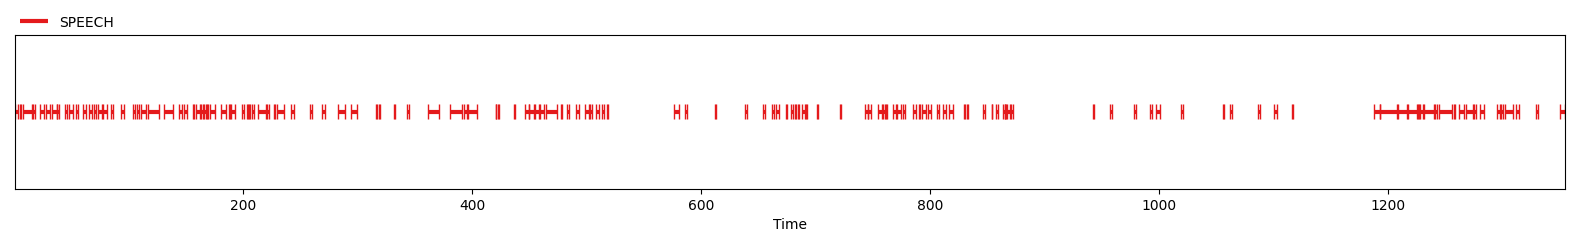

In [4]:
output

In [5]:
type(output)

pyannote.core.annotation.Annotation

In [6]:
print(output.get_timeline()) 
print(f"Speech Instances: {len(output.get_timeline())}")  

[[ 00:00:00.582 -->  00:00:03.197]
 [ 00:00:04.885 -->  00:00:06.319]
 [ 00:00:07.349 -->  00:00:15.499]
 [ 00:00:16.292 -->  00:00:17.912]
 [ 00:00:22.334 -->  00:00:26.468]
 [ 00:00:27.464 -->  00:00:31.446]
 [ 00:00:32.745 -->  00:00:37.032]
 [ 00:00:37.774 -->  00:00:39.225]
 [ 00:00:44.069 -->  00:00:46.110]
 [ 00:00:47.764 -->  00:00:51.004]
 [ 00:00:54.092 -->  00:00:55.645]
 [ 00:01:00.252 -->  00:01:02.665]
 [ 00:01:04.926 -->  00:01:07.643]
 [ 00:01:09.685 -->  00:01:11.659]
 [ 00:01:12.925 -->  00:01:16.452]
 [ 00:01:17.549 -->  00:01:21.244]
 [ 00:01:24.231 -->  00:01:26.661]
 [ 00:01:33.023 -->  00:01:35.807]
 [ 00:01:43.502 -->  00:01:45.831]
 [ 00:01:47.738 -->  00:01:48.970]
 [ 00:01:50.556 -->  00:01:55.197]
 [ 00:01:57.019 -->  00:02:06.334]
 [ 00:02:10.502 -->  00:02:18.450]
 [ 00:02:24.390 -->  00:02:26.854]
 [ 00:02:28.120 -->  00:02:31.259]
 [ 00:02:35.882 -->  00:02:37.232]
 [ 00:02:39.089 -->  00:02:42.143]
 [ 00:02:43.290 -->  00:02:44.657]
 [ 00:02:46.260 --> 

In [162]:
starts = []
ends = []
for o in output.get_timeline():
    start, end = list(o)
    start = np.floor(start)
    end = np.ceil(end)
    starts.append(start)
    ends.append(end)

In [165]:
predictions = pd.DataFrame({"Start Total Seconds": starts, "End Total Seconds": ends})

In [167]:
predictions["Diff"] = predictions["End Total Seconds"]-predictions["Start Total Seconds"]

### Testing

In [40]:
annotations = pd.read_csv("daniel_annotation.txt",  sep="==>", header=None, names=["Start Time", "End Time"])

In [41]:
annotations["End Time"] = annotations["End Time"].str.slice(0,-1)

In [71]:
annotations["Start Time"] = annotations["Start Time"].str.strip()
annotations["End Time"] = annotations["End Time"].str.strip()

In [75]:
annotations["Start Total Seconds"] = annotations["Start Time"].str.slice(0,2).astype(float)*60 + annotations["Start Time"].str.slice(3,5).astype(float)
annotations["End Total Seconds"] = annotations["End Time"].str.slice(0,2).astype(float)*60 + annotations["End Time"].str.slice(3,5).astype(float)

In [82]:
annotations["Diff"] = abs(annotations["Start Total Seconds"] - annotations["End Total Seconds"])

In [156]:
annotation_y = np.zeros(1355)

for index, val in annotations.iterrows():
    start = int(val["Start Total Seconds"])
    annotation_y[start:start+int(val["Diff"])] =  1

In [169]:
prediction_y = np.zeros(1355)

for index, val in predictions.iterrows():
    start = int(val["Start Total Seconds"])
    prediction_y[start:start+int(val["Diff"])] =  1

In [196]:
prediction_y[:100]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])

In [250]:
def remove_small_breaks(arr, n):
    counter = 0
    new_arr = np.copy(arr)
    for i in range(len(new_arr)):
        if i >= 200 and i <= 300:
            print(f"i: {i}")
            print(f"Counter: {counter}")
        if new_arr[i] == 0:
            counter += 1
        
        if i+1 < len(new_arr):
            if new_arr[i+1] == 1:
                if counter < n:
                    new_arr[i-counter+1:i+1] = 1
            
                counter = 0
        else:
            if counter < n:
                new_arr[i-counter+1:i+1] = 1
                counter = 0
    return new_arr

In [253]:
predictions_no_breaks = remove_small_breaks(prediction_y, 10)
print(predictions_no_breaks[200:300])
print(prediction_y[200:300])

i: 200
Counter: 0
i: 201
Counter: 0
i: 202
Counter: 0
i: 203
Counter: 0
i: 204
Counter: 0
i: 205
Counter: 0
i: 206
Counter: 0
i: 207
Counter: 0
i: 208
Counter: 0
i: 209
Counter: 0
i: 210
Counter: 0
i: 211
Counter: 1
i: 212
Counter: 2
i: 213
Counter: 0
i: 214
Counter: 0
i: 215
Counter: 0
i: 216
Counter: 0
i: 217
Counter: 0
i: 218
Counter: 0
i: 219
Counter: 0
i: 220
Counter: 0
i: 221
Counter: 0
i: 222
Counter: 0
i: 223
Counter: 0
i: 224
Counter: 1
i: 225
Counter: 2
i: 226
Counter: 0
i: 227
Counter: 0
i: 228
Counter: 0
i: 229
Counter: 0
i: 230
Counter: 0
i: 231
Counter: 0
i: 232
Counter: 0
i: 233
Counter: 0
i: 234
Counter: 0
i: 235
Counter: 0
i: 236
Counter: 0
i: 237
Counter: 1
i: 238
Counter: 2
i: 239
Counter: 3
i: 240
Counter: 4
i: 241
Counter: 5
i: 242
Counter: 0
i: 243
Counter: 0
i: 244
Counter: 0
i: 245
Counter: 0
i: 246
Counter: 1
i: 247
Counter: 2
i: 248
Counter: 3
i: 249
Counter: 4
i: 250
Counter: 5
i: 251
Counter: 6
i: 252
Counter: 7
i: 253
Counter: 8
i: 254
Counter: 9
i: 255
Cou

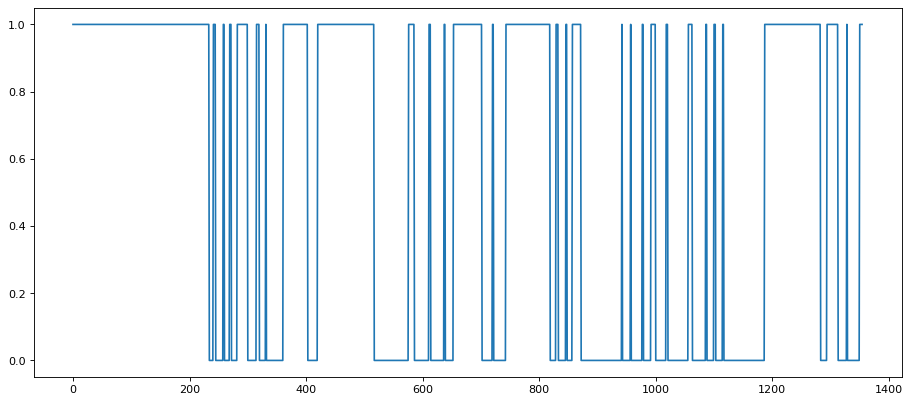

In [254]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(range(1355), annotation_y)
plt.show()

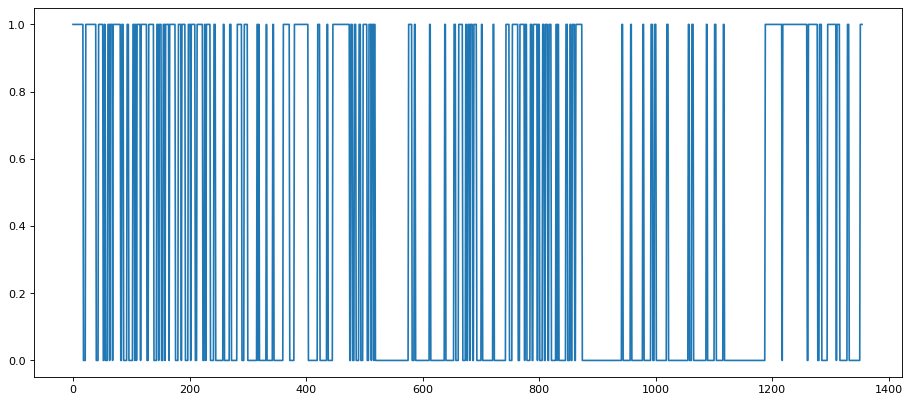

In [255]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(range(1355), prediction_y)
plt.show()

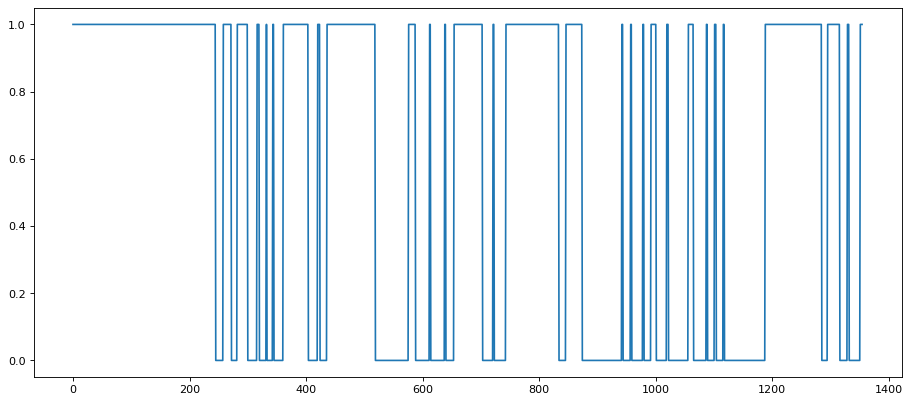

In [256]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(range(1355), predictions_no_breaks)
plt.show()

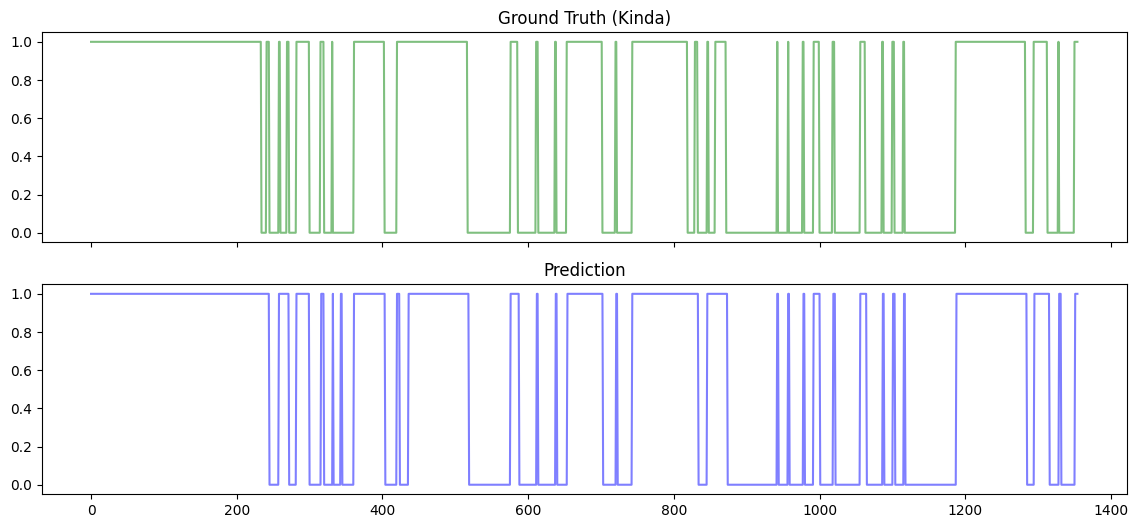

In [275]:
fig, axs = plt.subplots(2,1,sharex=True, sharey=True, figsize=(14,6))
axs[0].plot(range(1355), annotation_y, 'g' ,alpha=.5)
axs[1].plot(range(1355), predictions_no_breaks, 'b', alpha=.5)
axs[0].set_title("Ground Truth (Kinda)")
axs[1].set_title("Prediction")
plt.show()

### Speaker Diarization

In [16]:
SD = Pipeline.from_pretrained("pyannote/speaker-diarization")

In [18]:
sd_output = SD("Daniel Stream.wav")

KeyboardInterrupt: 

In [ ]:
sd_output